In [85]:
!pip install wget

In [0]:
import os
import re
from pathlib import Path
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [87]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

Archive:  20_newsgroups.zip
replace 20_newsgroups/talk.politics.mideast/75895? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 20_newsgroups/talk.politics.mideast/75895  
  inflating: 20_newsgroups/talk.politics.mideast/76248  
  inflating: 20_newsgroups/talk.politics.mideast/76277  
  inflating: 20_newsgroups/talk.politics.mideast/76045  
  inflating: 20_newsgroups/talk.politics.mideast/77197  
  inflating: 20_newsgroups/talk.politics.mideast/76421  
  inflating: 20_newsgroups/talk.politics.mideast/76283  
  inflating: 20_newsgroups/talk.politics.mideast/77351  
  inflating: 20_newsgroups/talk.politics.mideast/75406  
  inflating: 20_newsgroups/talk.politics.mideast/77369  
  inflating: 20_newsgroups/talk.politics.mideast/76089  
  inflating: 20_newsgroups/talk.politics.mideast/76419  
  inflating: 20_newsgroups/talk.politics.mideast/75892  
  inflating: 20_newsgroups/talk.politics.mideast/76284  
  inflating: 20_newsgroups/talk.politics.mideast/77356  
  inflating: 20_newsgroups

## Functions from lab

In [0]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [0]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [0]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [91]:
get_target("talk.politics.misc")

9

In [0]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [0]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [0]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [95]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9153390012145459
Test accuracy: 0.6926666666666667


### Q1 (a)

**Feature Set:** The features in the baseline model are unigrams (single terms). The frequency-based feature selection technique is adopted here with top 1000 frequently occuring words. Feature encoding used was binary encoding {0,1}. <br>
**Amount of Data:** The dataset is split randomly with 70% of the data used for training the model and the rest 30% in testing the model. <br>
**Hyperparameters:** The hyperparameter used in the baseline model for logistic regression is C i.e. Inverse of regularization strength. The default l2-regularization with C=1 is used inthe baseline. Setting very high value of C leads to avoiding regularization [https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul]    


### Q1 (b)

Modify the following function:

In [0]:
def corpus_count_cleanwords(file_list):
  tokenizer = RegexpTokenizer(r'\w+')
  word_counter = Counter()
  stop_words=set(stopwords.words('english'))
  stemmer = LancasterStemmer()
  for file_path in file_list:
      with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
          file_data = file.read()
          file_data = clean_file_text(file_data)
          file_words = tokenizer.tokenize(file_data)
          #convert to lowercase
          file_words = [word.lower() for word in file_words]
          #remove stopwords and perform stemming
          file_words = [stemmer.stem(word) for word in file_words if word not in stop_words]
          #remove numbers
          new_words=[]
          for word in file_words:
            new_word = re.sub(r'[\d+]', '', word)
            if new_word != '':
              new_words.append(new_word)
          word_counter.update(new_words)
  return word_counter

In [97]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    news_cnt = corpus_count_cleanwords(file_list)
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    stop_words=set(stopwords.words('english'))
    stemmer = LancasterStemmer()
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            #convert to lowercase
            file_words = [word.lower() for word in file_words]
            #remove stopwords and perform stemming
            file_words = [stemmer.stem(word) for word in file_words if word not in stop_words]
            #remove numbers
            new_words=[]
            for word in file_words:
              new_word = re.sub(r'[\d+]', '', word)
              if new_word != '':
                new_words.append(new_word)
            df_rows.append([1 if word in new_words else 0 for word in word_list])
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [99]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9392727012931342
Test accuracy: 0.7548333333333334


**Training accuracy**(from *binary_improved_data*): 93.92% <br>
**Testing accuracy**(from *binary_improved_data*): 75.48%<br>


*   Training accuracy increased by 2.4% from the baseline
*   Testing accuract increased by 6.2% from the baseline



### Q1 (d)

Modify the partial code below

In [0]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in list(range(num_tests)):
      # split to train and test set
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      # train a logistic regression classifier
      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)

      # calculate train and test accuracy
      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)
      train_results.append(train_accuracy)
      test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [101]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9403729370579409
Train confidence interval over 10 random splits: [0.93965008227507, 0.9410957918408118]
Test mean accuracy over 10 random splits: 0.7557166666666666
Test confidence interval over 10 random splits: [0.7529638016515471, 0.7584695316817861]


**Average:** In this case it is the mean of the 10 accuracies obtained with random split.<br>
**95% Confidence Interval (CI):** The intervals for the average accuracy that should hold 95 out of 100 times on re-running the randomized experiment.<br>
**Comparison with the single trial:** Results of the average and CI from the multiple trails are more informative because it is highly probable that we might get lucky with a single trail split. Thus, with multiple trails it is possible to gauge the consisteny of the model and how well it generalizes.  

### Q1 (f)

Modify the partial code below

In [0]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in list(range(num_tests)):
      # split to train and test set
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      # train a logistic regression classifier
      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)

      cm = confusion_matrix(y_test, y_test_predict)
      cm_list.append(cm)
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

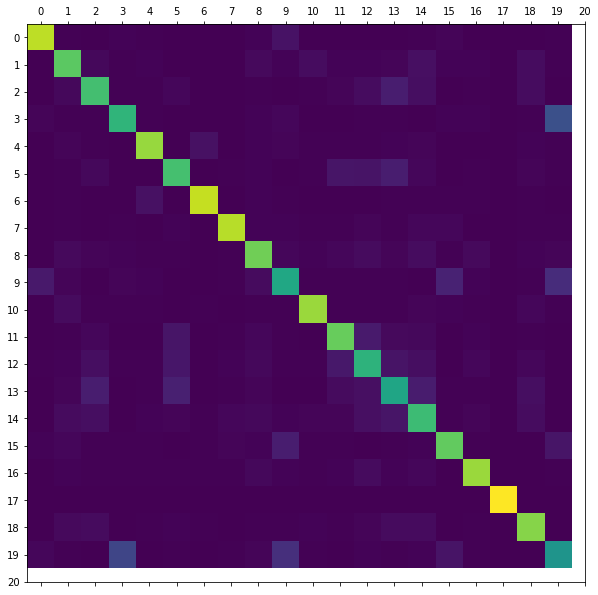

In [103]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

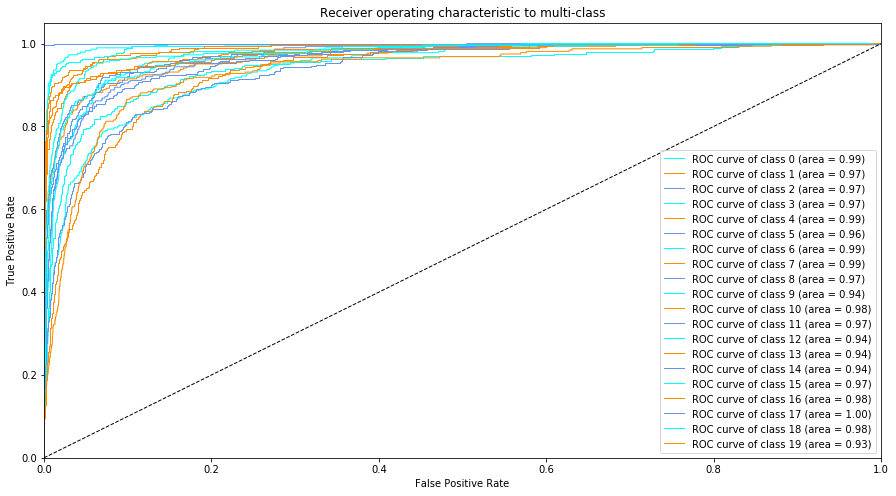

In [104]:
# Ref for ROC: [https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html]
y_score = clf.decision_function(X_test)
y_test_bin = label_binarize(y_test, classes=list(range(20)))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=20
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Best Predicted Class:** 17 (soc.religion.christian)<br>
**Reason for best performance compared to other classes:**  There is only single parent class (soc) thus leading to better disctinction from the other classes <br>
**Worst Predicted Class:** 19 (talk.religion.misc) <br>
**Reason for worst performance compared to other classes:**  This is wrongly classified to class 3-alt.atheism and class 9- talk.politics.misc. This is because topic of atheism (class 3) is quite related to the religious talk(class 19). Also, class 9 has the same parent topic (talk) which leading to vauge distinction.


## Q2

### Q2 (a)

Modify the partial code below

In [0]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

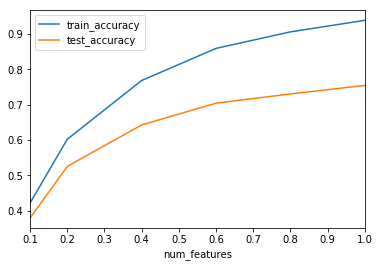

In [106]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

**Trend with the number of features:** Training and testing accuracy increases with the increase in the number of features and the rate of increase in accuracy decreases as the features becomes less common (frequency-based)

## Q3

### Q3 (a)

Modify the partial code below

In [0]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

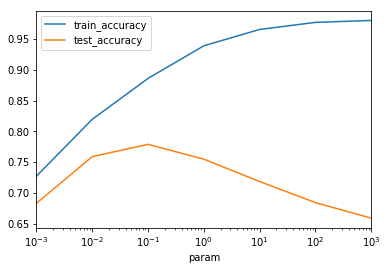

In [108]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

The testing accuracy increases with the training accuracy until parameter (C = 0.1) and then testing accuracy goes on decreasing due to overfitting. Thus, for optimal fit, the parameter (C= 0.1)

## Q4

### Q4 (a)

Modify the partial code below

In [0]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    # Calculate word count in corpus
    news_cnt = corpus_count_cleanwords(file_list)
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words=set(stopwords.words('english'))
    stemmer = LancasterStemmer()
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            #convert to lowecase
            file_words = [word.lower() for word in file_words]
            #remove stopwords and perform stemming
            file_words = [stemmer.stem(word) for word in file_words if word not in stop_words]
            new_words=[]
            #remove numbers
            for word in file_words:
              new_word = re.sub(r'[\d+]', '', word)
              if new_word != '':
                new_words.append(new_word)
            file_words_count=Counter(new_words)
            df_rows.append([file_words_count[word] for word in word_list])
    
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [110]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9346074158748303
Train confidence interval over 10 random splits: [0.932001075781131, 0.9372137559685296]
Test mean accuracy over 10 random splits: 0.7447
Test confidence interval over 10 random splits: [0.7402964086589973, 0.7491035913410028]


Binary encoding performed a bit better than the term frequency encoding because a higher term frequency leads to more weight in determining the final class due to which low frequent terms play a negligible role.    

## Q5

### Q5 (a)

Modify the partial code below

In [0]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in list(range(num_tests)):
      # split to train and test set
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      # train a logistic regression classifier
      gnb = MultinomialNB().fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = gnb.predict(X_train)
      y_test_predict = gnb.predict(X_test)

      # calculate train and test accuracy
      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)
      train_results.append(train_accuracy)
      test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [112]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7887190112166893
Train confidence interval over 10 random splits: [0.7871481795012912, 0.7902898429320874]
Test mean accuracy over 10 random splits: 0.7387333333333334
Test confidence interval over 10 random splits: [0.7350055374861082, 0.7424611291805585]


Logistic Regression performed better because the Naive Bayes assumes the feature independence and if there are no occurrences of a class label and a certain attribute value together then the frequency-based probability estimates are zero. [https://discuss.analyticsvidhya.com/t/zero-frequency-problem/2521]  

## Q6

### Q6 (a)

Modify the partial code below

In [0]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    # Calculate word count in corpus
    news_cnt = corpus_count_cleanwords(file_list)
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words=set(stopwords.words('english'))
    stemmer = LancasterStemmer()
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            #Convert to lowecase
            file_words = [word.lower() for word in file_words]
            #Remove Stopwords and perform stemming
            file_words = [stemmer.stem(word) for word in file_words if word not in stop_words]
            #Remove Numbers
            new_words=[]
            for word in file_words:
              new_word = re.sub(r'[\d+]', '', word)
              if new_word != '':
                new_words.append(new_word)
            df_rows.append([1 if word in new_words else 0 for word in word_list])
            
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    y= [1 if target==8 else 0 for target in y]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [114]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9921483174966064
Train confidence interval over 10 random splits: [0.9917595018480644, 0.9925371331451484]
Test mean accuracy over 10 random splits: 0.9754333333333334
Test confidence interval over 10 random splits: [0.9738877813977028, 0.9769788852689639]


**Average:** In this case it is the mean of the 10 accuracies obtained with random split.<br>
**95% Confidence Interval (CI):** The intervals for the average accuracy that should hold 95 out of 100 times on re-running the randomized experiment.<br>
**Comparison with the multi-class classification:** The average of the binary classification was obtained to be greater than the multi-class classification and had a lower variance in the results.   